In [ ]:
#@title imports libraries { vertical-output: true, display-mode: "both" }
# !pip install "nltk==3.4.5"
import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Vocabulary
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib
import math
# nltk.download('punkt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


###**Part 1: Language Models.**

1. Data Exploratin.
    




##1. Gathering Basic Statistics.

In [ ]:
path_data = "/content/drive/My Drive/NLP/simple-examples/data/ptb."
path_char_data = "/content/drive/My Drive/NLP/simple-examples/data/ptb.char."
def top_N(n, word_counter):
  total_top_words = np.sum([freq for word, freq in word_counter.most_common(n)])
  return total_top_words


def token_type_ratio(word_counter):
  total_freq = np.sum([freq for word, freq in word_counter.most_common()])
  return total_freq / len(word_counter)


def proccess_data(subname, opt=0):
  word_data = open(path_data + subname + ".txt" if opt==1 else subname + ".txt" ).read()
  char_data = open(path_char_data + subname + ".txt" if opt==1 else subname + ".txt").read()
  sentences = word_data.split('\n')
  words = word_data.split()
  chars = char_data.split()
  word_counter = Counter(words)                     
  distinct_words = len(word_counter)              # number of distinct words
  ratio = token_type_ratio(word_counter)
  word_set = set(words)                           # all the distinct words
  return {"sentences": sentences , "words_tok":words, "chars_tok": chars, "word_counter": word_counter, "word_set": word_set, "distinct_words": distinct_words, "ratio": ratio}



now for each file (train, valid, test), we're going to gather some statistics.

each dataset contains basic statistics that have been gathered above. 



In [ ]:
# for each file, we gather it's information using the helper function proccess.
train_dtset = proccess_data('train', 1)
valid_dtset = proccess_data('valid', 1)
test_dtset = proccess_data('test', 1)


Let's explore each file:

In [ ]:
dtafile_names = ['train', 'valid', 'test']
dtafile_dataset = [train_dtset, valid_dtset, test_dtset]

for i in range(len(dtafile_names)):
  print("############################################################")
  print("###################### %s DATA SET ######################" % (dtafile_names[i]))
  print("############################################################\n\n")
  print('\tNumber of Tokens in %s data set : \t\t\t%d\n' % (dtafile_names[i], len(dtafile_dataset[i]['words_tok'])))
  print('\tTotal number of characters in %s data set : \t\t%d\n' % (dtafile_names[i], len(dtafile_dataset[i]['chars_tok'])))
  print('\tThe total number of distinct words in %s data set : \t%d\n' % (dtafile_names[i], dtafile_dataset[i]['distinct_words']))
  print('\tThe token/type ratio in %s data set : \t%d\n' % (dtafile_names[i], dtafile_dataset[i]['ratio']))




############################################################
###################### train DATA SET ######################
############################################################


	Number of Tokens in train data set : 			8177117

	Total number of characters in train data set : 		4975414

	The total number of distinct words in train data set : 	10031

	The token/type ratio in train data set : 	815

############################################################
###################### valid DATA SET ######################
############################################################


	Number of Tokens in valid data set : 			70390

	Total number of characters in valid data set : 		389672

	The total number of distinct words in valid data set : 	6021

	The token/type ratio in valid data set : 	11

############################################################
###################### test DATA SET ######################
############################################################


	Number o

Let's print The total number of tokens corresponding to the top- 5 most frequent words in the vocabulary using our top_N function.

In [ ]:
n = 5
for i in range(3):
  print("Total number of tokens corresponding to top %d most frequent words in %s data set= %d" %(n,  dtafile_names[i], top_N(n, dtafile_dataset[i]['word_counter'])))

Total number of tokens corresponding to top 5 most frequent words in train data set= 1634386
Total number of tokens corresponding to top 5 most frequent words in valid data set= 13792
Total number of tokens corresponding to top 5 most frequent words in test data set= 16083


we can even print our top n frequent words in our vocabulary, for example, let's print out 5 most common words with thier frequency in train data set.



In [ ]:
 n = 5
print(train_dtset['word_counter'].most_common(n))

[('the', 465697), ('<unk>', 409213), ('N', 315125), ('of', 224887), ('to', 219464)]


we notice that the word "<`unk>" is frequently used in our vocabulary. 


we're going now to print the The number of types that appear in the dev data but not the training data.

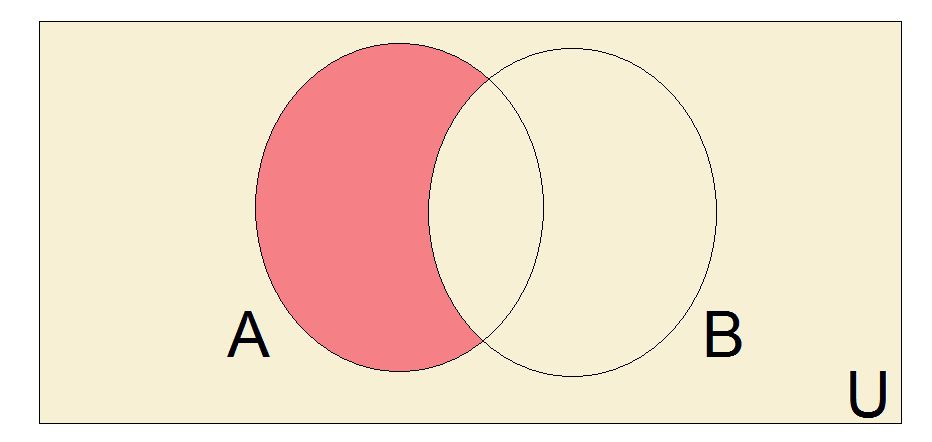


In [ ]:
print(len(valid_dtset['word_set'] - train_dtset['word_set']))

0


awesome! now we know that all the words that in validating set are in our training data set. 

we'll compute now the average number and standard deviation of characters per token.




In [ ]:
'''
there is a function in numpy library called std which compute the standard deviation along the specified axis.
you can read about it's API here:   https://numpy.org/doc/stable/reference/generated/numpy.std.html '''

def mean_dataset(dataset):
    return np.sum([freq for word, freq in dataset['word_counter'].most_common()]) / dataset['distinct_words']

def calculate_std(dataset):
  mean = mean_dataset(dataset)
  return np.sqrt((np.sum([np.square(np.abs(freq - mean)) for word, freq in dataset['word_counter'].most_common()]) / dataset['distinct_words']))

# print(calculate_std(train_dtset))

print('average number and standard deviation of characters per token = %.10f' %(np.std([len(word) for word in train_dtset['words_tok']])))

average number and standard deviation of characters per token = 2.6030258422


for building an n-gram model, we introduce a way to build n-gram dataset: 


In [ ]:
def n_gram_1(text, n):
  res = []
  for i in range(len(text) - n):
    cond = tuple(text[i:i+n])
    sample = text[i+n]
    res.append(fst)
  return res

# an elegant way to do the above:
def n_gram(text, n):
  return zip(*(text[i:] for i in range(n)))


so we can print some information about our n-gram that we have built.

here, we are showing the # of distinct words/chars in n-gram for ${n}\in[2,5]$

In [ ]:
def print_distinct_gram(text, opt, fst, end):
  for i in range(fst,end):
    my_gram = n_gram(text, i)
    gram_counter = Counter(my_gram)
    print("Total number of distinct %s in %d-gram : %d" % (opt,i, len(gram_counter)))

print_distinct_gram(train_dtset['words_tok'],'words', 2, 5)
print_distinct_gram(train_dtset['chars_tok'], 'chars', 2,8)

Total number of distinct words in 2-gram : 277547
Total number of distinct words in 3-gram : 615726
Total number of distinct words in 4-gram : 771638
Total number of distinct chars in 2-gram : 958
Total number of distinct chars in 3-gram : 9418
Total number of distinct chars in 4-gram : 48379
Total number of distinct chars in 5-gram : 154572
Total number of distinct chars in 6-gram : 369781
Total number of distinct chars in 7-gram : 703050


ofcourse, the more the sequence contains words, the less it's frequency appears in the data set.  

**1.1.2** **Zipf and Power Law**

let's verify that our plot of the log-frequency against rank-frequency is nearly linear. 

Text(0, 0.5, 'frequency')

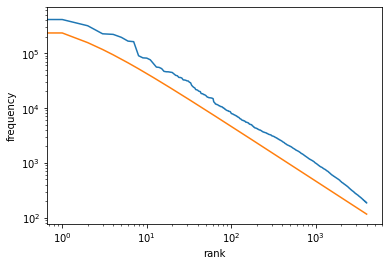

In [ ]:
# the nth most frequent word appears with a frequency of about 1/n of the most frequent word
M = train_dtset['word_counter'].most_common(1)[0][1]
plt.loglog([freq for word, freq in train_dtset['word_counter'].most_common(4000)])
plt.loglog([M / i for i in range(1,4000)])

plt.xlabel('rank')
plt.ylabel('frequency')

it appears that our data set follows the power law distribution, as our plot is almos linear.


##1.2 n-gram Word Language Model

**1.2.1 How much memory do you expect a model to occupy?**




A language model(LM) is a probability distribution P(S) that describes how often a string wn1=w1···wn drawn from the set S appears in some domain of interest

In [ ]:
V = len(train_dtset['words_tok'])
print('Our Vocabulary contains %d words' % (V))

Our Vocabulary contains 8177117 words


In [ ]:
import pandas as pd
df = pd.DataFrame({'N': ['2 (bigrams)', '3 (trigrams)', '4 (4-gram)'], 'Number Of bins' : [V**2,V**3,V**4]})
df

,N,Number Of bins
0,2 (bigrams),66865242431689
1,3 (trigrams),546764910597285460613
2,4 (4-gram),4470960645448543093831392721


A lot of memory :\



**1.2.2 N-gram LM**

We present a Python function to construct a word n-gram model given a dataset according to the signature:

train_word_lm(dataset, n=2)


In [ ]:
# creating language model with MLE smoothing teq:
def create_lm(fname, order=4):
  pad = ['*']*order
  data = pad + fname
  cfd = nltk.ConditionalFreqDist((' '.join(list(data[i: i + order])), data[i + order]) for i in range(len(data) - order))
  cpd = nltk.ConditionalProbDist(cfd, nltk.MLEProbDist)
  return cpd


In [ ]:
n = 2
train_dataset_lm = create_lm(train_dtset['words_tok'], n)

now that we have construct our n-gram language model dataset, we can provide some useful information using nltk libraries

In [ ]:
print(train_dataset_lm['aer banknote'].samples())
# Return the sample with the greatest number of outcomes in this frequency distribution
print(train_dataset_lm['aer banknote'].max())
print(train_dataset_lm['aer banknote'].prob('berlitz'))
print(train_dataset_lm['calloway centrust'].samples())
print(train_dataset_lm['aer banknote'].generate())

dict_keys(['berlitz'])
berlitz
1.0
dict_keys(['cluett'])
berlitz


Even better, we can print all pairs (history = h, word = w)  such that $P(w|h) < 0.5$. 


In [ ]:
p = 0.5
top = 5

def less_than(lm, p):
  _dct = {}
  for sent in lm.conditions():
    for sampl in lm[sent].samples():
      if lm[sent].prob(sampl) < p:
        _dct[sent,sampl] = lm[sent].prob(sampl)
  return _dct 

def visualized(lm, p):
  less_than_p = Counter(less_than(lm, p))
  print('there are %d pairs (history , word) such that P(w|h) < %.1f .'%(len(less_than_p), p))
  print('\nprining first 5: ')
  print('----------------')
  for idx, sample in enumerate(less_than_p.most_common(top)):
    h = sample[0][0]
    w = sample[0][1]
    p_hw = sample[1]
    print('%d- P(%s | %s) = %.5f' % (idx+1,w, h, p_hw))


visualized(train_dataset_lm, p)

there are 356965 pairs (history , word) such that P(w|h) < 0.5 .

prining first 5: 
----------------
1- P($ | share or) = 0.49817
2- P(said | industry executives) = 0.49801
3- P(that | to believe) = 0.49744
4- P(the | it completed) = 0.49708
5- P(N | advanced N) = 0.49669


Another example of how we can use some usefull methods for presenting basic information about our model.

In [ ]:
def p_of_history(lm, h):
   try:
    samples = list(lm[h].samples())
    for sampl in samples:
      print('P(%s | %s) = %f' % (sampl, h, lm[h].prob(sampl)))
   except:
     print('try again with different history!\n')


In [ ]:
history = 'i love'
p_of_history(train_dataset_lm, history)

P(this | i love) = 0.100000
P(pilson | i love) = 0.900000


so far we have construct a language model based on n-gram corpus that we have build from our data set, but how good is our model?

to answear that we need to evaluate the performance of the learned language models by using two techniques:


1.  measuring perplexity on a validation dataset and using the model to  generate random text.
2.   assessing the readability of the generated text.



##1.3 Language Model Evaluation


* 1.3.1 Perplexity

*Perplexity is a popularly used measure to quantify how "good" such a model is. If a sentence s contains n words then perplexity :*
$PP(s) = P(w_1,...,w_n)^{-1/n}$

transfering the above formula to python code yields the following algorithim:

In [ ]:
# default bigram

def perplexity(lm, gram_s, pen):
  pp_s = 1
  for s in gram_s:
    cond = ' '.join(list(s[:-1]))
    try:
        p = lm[cond].prob(s[-1])
        if p != 0:
          pp_s *= p
        
        else: 
          1/pen  
    except: # means that this gram ("sentence") is not in the model
      return -1

  return  pp_s**(1/len(gram_s))


def avg_perplexity(lm, dataset):
  pps = []
  pen = len(dataset)
  for sent in dataset:
    sent_to_gram = list(n_gram(sent.split(), n+1))
    if len(sent_to_gram) != 0:
      pp_s = perplexity(lm, sent_to_gram, pen)
      if pp_s != -1:
        pps.append(pp_s)

  return np.sum(pps)/len(pps)


**printing the perplexity of our model**.


but wait, if we calculate the perplexity of our model using different dataset (from the training dataset) it may return 0. this because our model only recognize his training data. so, giving a history of words $h = w_1...w_s$ and an arbitirary word $w$ that not in training dataset:
rewriting the above formula using chain rule yields the following equation:

$ PP(S) = PP(wh) = P(w) * P(w_1|w) *...*P(w_s|w_1...w_{s-1})$.

since $w$ not in our dataset, we get $P(w) = 0 $ and thus, $PP(s) = 0$.
to solve that we need to **'smooth'** our model, but before doing that, we can calculate the average perprlexity of the model, that is, we only consider those $h, w$ that our model recognize.
 

In [ ]:
# avg_train = avg_perplexity(train_dataset_lm, train_dtset['sentences'][:2])
avg_valid = avg_perplexity(train_dataset_lm, valid_dtset['sentences'])
print(avg_valid)

0.45284763729451366


the resault is obvious, we get a low perplexity value which means that our model is good! BUT nah, we get low perplexity because we only considered h, w that in our training dataset. 

from gathering data siction, we saw that all the words in the trainig dataset are in the validate data set. taht's cool, but does it have the same n-gram?
that is, does both file contains the same frequency of such a word? the answear is giving above.

In [ ]:
'''
>>> list(ngrams([1,2,3,4,5], 2, pad_right=True))
        [(1, 2), (2, 3), (3, 4), (4, 5), (5, None)]
        >>> list(ngrams([1,2,3,4,5], 2, pad_right=True, right_pad_symbol='</s>'))
        [(1, 2), (2, 3), (3, 4), (4, 5), (5, '</s>')]
        >>> list(ngrams([1,2,3,4,5], 2, pad_left=True, left_pad_symbol='<s>'))
        [('<s>', 1), (1, 2), (2, 3), (3, 4), (4, 5)]
        >>> list(ngrams([1,2,3,4,5], 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>'))
        [('<s>', 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, '</s>')]

'''
n = 2

def train_lm(train_sentences, n):
  pad = ['*' for i in range(n)]
  tokenized_text = pad + [list(map(str.lower, nltk.word_tokenize(sent))) for sent in train_sentences]
  train_data = [nltk.ngrams(seq, n,pad_right=True, pad_left=True, left_pad_symbol='*', right_pad_symbol= '*') for seq in tokenized_text] 
  words = [word for sent in tokenized_text for word in sent]
  padded_vocab = Vocabulary(words)
  #Build our model
  model = MLE(n)
  model.fit(train_data, padded_vocab)
  return model
  
model_lm_mle = train_lm(train_dtset['sentences'], n)



After creating and training our n-gram model, we can now test it in our test data set

In [ ]:
#Testing model
import math

res = []
def test_model_sentence(lm, sentence, n):
  sent = list(n_gram(sentence, n))
  if len(sent) != 0:
    p = lm.perplexity(sent)
    if math.isinf(p)==False:
      res.append(p)   

def test_model(lm, sentences):
  for sent in sentences:
    _sent = sent.split()
    test_model_sentence(lm, _sent, n)
  return np.sum(res)/len(res)  


def test_generate(lm, n=2):
  start = ['*' for i in range(n)]
  out = []
  for _ in range(10):
    word = lm.generate(random_seed=3)
    start = start[:1] + word
    out.append(word)

  print(' '.join(out))  


# test_model(model_lm, test_dtset['sentences'])

In [ ]:
def calc_perp(model_lm, dataset, n=2):
  res = []
  pen = 1/len(dataset)
  for sent in dataset:
    sent_to_gram = list(n_gram(sent.split(), n))
    if len(sent_to_gram) != 0:
      try:
        perp = model_lm.perplexity(sent_to_gram)
        if perp != 0 and math.isinf(perp)==False:
          res.append(res)
      except:
        res.append(pen)  
  return np.sum(res)/len(res)    


calc_perp(model_lm_mle, valid_dtset['sentences'])

0.0002966478789676653

in some cases, we encounter a word that is not in our dataset and thus giving us probability of 0. Now wer'e going to 'smooth' the model, that is, flatten the probabilities like: giving some $S_1 = h_1w_1$, $ S_2 = h_2w_2$ such that $P(w_1 | h_1) = p_1 $, and $P(w_2 | h_2) = p_2$ and $ p_2 = 0.000..1.. $ (close to 0) and $p_1 > 0.6$

after smoothing we get something like this:

$P(w_2 | h_2) = p_2 + (\epsilon > 0) $

$P(w_1 | h_1) = p_1 - \epsilon $




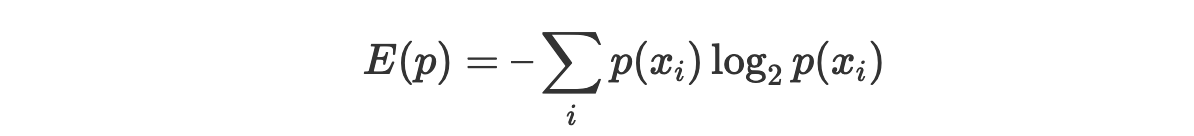

**Laplace-smoothed bigrams** :  
> $ p(w_n|w_n-1) = \frac{C(w_{n-1}w_n) + 1}{C(w_{n-1}) + V} $.

> $ C(w_{n-1}w_n) = \frac {[C(w_{n-1}w_n) + 1] * C(w_{n-1})}{C(W_{n-1}) + V} $


*   Laplace smoothing not often used for N-grams, as we have much better methods.
*   Despite its flaws, Laplace (add-k) is however still used to smooth other probabilistic models in NLP, especially
 > * For pilot studies.
 > * In domains where the number of zeros isn’t so huge.


---




> Minimizing perplexity is the same as maximizing probability.
The best language model is one that best predicts an unseen test set

> **Smoothing is like Robin Hood: Steal from the rich, give to the poor (probability mass) :)**

In [ ]:
#@title create_lm_smooth
from nltk import LidstoneProbDist, FreqDist
V = len(train_dtset['word_counter'])
n = 2
gamma = 0.5

def train_lm_test(dataset, n=2):
  fdist = defaultdict(FreqDist)
  dataset = ['*']*n + dataset
  for i in range(len(dataset) - n):
    cond = ' '.join(dataset[i : i + n])
    word = dataset[i + n]
    fdist[cond][word] += 1
  return fdist  

def create_lm_smooth(dataset, order, smooth_teq, moreParam=None):
  pad = ['*']*order
  dataset = pad + dataset
  cfd = nltk.ConditionalFreqDist((' '.join(list(dataset[i: i + order])), dataset[i + order]) for i in range(len(dataset) - order))
  cpd = nltk.ConditionalProbDist(cfd, smooth_teq, moreParam)
  return cpd


lidstone_lm = create_lm_smooth(train_dtset['words_tok'], n, nltk.LidstoneProbDist, gamma)
laplace_lm = create_lm_smooth(train_dtset['words_tok'], n, nltk.LaplaceProbDist)


we can compare our original model (MLE) and the smoothing model, like laplace
to actually see the 'smoothing'.

wer'e going to do that with our helper-function *less_than()*.
apllying this function to different smoothing model yields different probability for each sample for each model!

In [ ]:
num_of_ps_to_print = 5
n = 3
p = 0.5
models = [train_dataset_lm, laplace_lm, lidstone_lm]
models_names = ['MLE', 'LAPLACE', 'LIDSTONE']

for i in range(n):
  j = 0
  print('--------------')
  print('Model: %s' % (models_names[i]))
  print('--------------')
  visualized(models[i], p)
  print('\n---------------------------------------------------------')

--------------
Model: MLE
--------------
there are 356965 pairs (history , word) such that P(w|h) < 0.5 .

prining first 5: 
----------------
1- P($ | share or) = 0.49817
2- P(said | industry executives) = 0.49801
3- P(that | to believe) = 0.49744
4- P(the | it completed) = 0.49708
5- P(N | advanced N) = 0.49669

---------------------------------------------------------
--------------
Model: LAPLACE
--------------
there are 358579 pairs (history , word) such that P(w|h) < 0.5 .

prining first 5: 
----------------
1- P(this | contributed to) = 0.49834
2- P(vice | an executive) = 0.49784
3- P(N | that N) = 0.49767
4- P(meeting | shareholders ') = 0.49741
5- P(be | may not) = 0.49726

---------------------------------------------------------
--------------
Model: LIDSTONE
--------------
there are 358134 pairs (history , word) such that P(w|h) < 0.5 .

prining first 5: 
----------------
1- P(to | it expects) = 0.49953
2- P(for | the need) = 0.49911
3- P(N | in october) = 0.49903
4- P(vice 

In [ ]:

def E_p(lm, dataset, gamma=1,n=2):
  dataset = ['*']*n + dataset
  res = 0
  for i in range(len(dataset) - n):
    cond = ' '.join(dataset[i : i + n])
    word = dataset[i + n]
    lidstone = LidstoneProbDist(lm[cond], gamma=gamma, bins=V)
    res += np.log2(lidstone.prob(word))
      
  return -res/(len(dataset)-n)  


def perp_using_E_p(lm, dataset, gamma, n):
  return 2**(E_p(lm, dataset, gamma, n))



**1.3.2 Perplexity according to the order of the n-gram model**

* computing perplexity of the trained model on the validation dataset for different Lidstone estimators: 

In [ ]:
# Draw graph of perplexity of bigram LM for values of gamma with Lidstone estimator as smoothing method
gammas = [(1/i) for i in range(1,21)]
l_model = train_lm_test(train_dtset['words_tok'])
perps = [perp_using_E_p(l_model, valid_dtset['words_tok'], gamma, 2) for gamma in gammas]

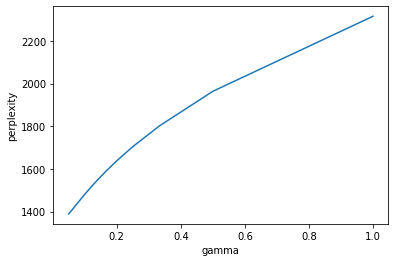

In [ ]:
plt.xlabel('gamma')
plt.ylabel('perplexity')
plt.plot(gammas, perps)
plt.show()

So we can infer from the plot that the less the gamma -> less perplexity in our langauge model.

from the above graph, for $ gamma = 1/20$ we get less perplexity,
giving this, we're going now to draw a graph of the obtained perplexity on the validation dataset for different values of n between 2 and 20: 

In [ ]:
gamma = (1/20)

diff_models = [train_lm_test(train_dtset['words_tok'], n) for n in range(2,21)]
diff_models_perps = [perp_using_E_p(diff_models[i], valid_dtset['words_tok'], gamma, n=i+2) for i in range(len(diff_models))]

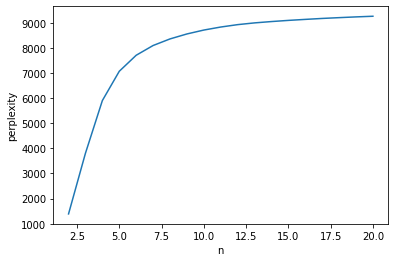

In [ ]:
plt.xlabel('n')
plt.ylabel('perplexity')
plt.plot(range(2,21), diff_models_perps)
plt.show()

In [ ]:
# best model from our graph is built using 2-gram
best_gamma = (1/20)
best_model_lidstone = train_lm_test(train_dtset['words_tok'], 2)
best_perp = perp_using_E_p(best_model_lidstone, test_dtset['words_tok'], best_gamma, n=2)
print(best_perp)

1399.58627512435


**1.3.4 Test the best n-gram LM**

* Good Turing 

> $N[x]$ is the frequency-of-frequency-$x$.

> $ N[1] = 10$ means there are 10 distinct words occured exactly 1 times in our corpus.

> $c_* = (c + 1) N[c + 1] / N[c]$


In [ ]:
# calculating perpexity with simple good turing
def E_p_gt(lm, dataset,n=2):
  dataset = ['*']*n + dataset
  res = 0
  for i in range(len(dataset) - n):
    cond = ' '.join(dataset[i : i + n])
    word = dataset[i + n]
    good_turing = nltk.SimpleGoodTuringProbDist(lm[cond], bins=V)
    p = good_turing.prob(word) 
    if p != 0 and math.isinf(p)==False:
      res += np.log2(p)
    else:
      res += 1/(len(dataset))
  return -res/(len(dataset)-n)  


def perp_using_E_p_gt(lm, dataset, n):
  return 2**(E_p_gt(lm, dataset, n))


In [ ]:
good_turing_lm_perp = perp_using_E_p_gt(l_model, test_dtset['words_tok'], 2)
print(good_turing_lm_perp)

/usr/local/lib/python3.6/dist-packages/nltk/probability.py:1422: UserWarning: SimpleGoodTuring did not find a proper best fit line for smoothing probabilities of occurrences. The probability estimates are likely to be unreliable.
  'SimpleGoodTuring did not find a proper best fit '


573.3599556380234


In [ ]:
# perplexity of smoothing model using Laplace

def calc_laplace_perp(lm, dataset, n=2):
  dataset = ['*']*n + dataset
  res = 0
  for i in range(len(dataset) - n):
    cond = ' '.join(dataset[i : i + n])
    word = dataset[i + n]
    try:
      if lm[cond].prob(word) != 0:
        res += np.log2(lm[cond].prob(word))
    except:
      res += 1/len(dataset)  
  return -res/(len(dataset)-n) 

def perp_laplace(lm, dataset, n):
  return 2**(calc_laplace_perp(lm, dataset, n))


perp_laplace(laplace_lm, test_dtset['words_tok'], n=2)

17.233748443332495

**1.3.5 Generating Text from a Language Model**.


Another way to evaluate a language model is to use the model in a generative manner - that is, to randomly sample sentences starting from a seed prefix, and generating each next word by sampling from the model distribution p(w|prefix)



We experiment with a variety of seeds..

In [ ]:
# Test generate it on the best model trained above

def generate(model, seed=' ', num_words=1):
  out = []
  for _ in range(num_words):
    try:
      word = model[seed].generate()
      seed = seed[1:] + ' '+word
      # print(seed,' -> ' ,word)
      out.append(word)
    except:
      seed = seed[1:] 
  return out



* We first test the case where seed = '* *', first word in the dataset.
  > ofcourse the first word we except to get using the above seed is "aer"
    since we pad our dataset with '* *', so the first word in our original vocab would have 'history' so we can caclcualte P('aer'|history=seed).


In [ ]:
# working in bigram, lidstone model
res = generate(lidstone_lm, seed='* *', num_words=1000)
print(' '.join(res))


aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter pierre <unk> an analyst at smith barney harris upham & co. said that its bookings more than N years from now if the government issues its first quarter N N bond due N rose N to N N gain in consolidated new york stock exchange composite trading schering-plough shares fell initially on questions of the c$ N million but the session when a david baltimore who has held senior sales positions at polaroid the personnel policy planning committee known as <unk> <unk> a special shareholder meeting to vote for the support staff with respect to highly classified <unk> between the corporate bond issues on the show 's <unk> he has taken its toll on earnings or return on equity we view it as soon as the dominant partner in six trading days a week bankamerica 's total of N yen in the heavy activity in the latest period to $ N mil

* Then the case where seed=(w1 w2) where w1 = most common word, w2 = second most common word!

In [ ]:
w1 = train_dtset['word_counter'].most_common(1)[0][0]
w2 = train_dtset['word_counter'].most_common(2)[1][0]
seed = w1 + ' ' + w2
res1 = generate(lidstone_lm, seed=seed, num_words=1000)
print(' '.join(res1))

offering of N they were introduced only one part of the property would trigger <unk> sentiment last summer and establishing the office and residential mortgages which rose $ N million the <unk> <unk> founder will retire nov. N the company sold his N estimate to between $ N both men were scheduled to be determined until state officials could n't take the <unk> called the market the new deal was being strongly criticized in the general assembly the proposed settlement customers with valid claims of momentum even though the epicenter was n't identified vision banc insider from insured financial institutions have driven individual investors i think it might have entered the high-definition television or hdtv which is <unk> they pay on their ag stock since the start of the class c warrants to holders of the hole for mr. <unk> calls the ranch the team 's <unk> will make them directly comparable lending practices in the cracks said mark <unk> the campaign by wooing a core black audience they 

it make sense now! 

## 1.4 Character language model

* 1.4.1 Read and Summarize

* **The Unreasonable Effectiveness of Recurrent Neural Networks :**
so what makes Recurrent Networks so special?
they allow us to operate over sequences of vectors: Sequences in the input, the output, or in the most general case both
RNNs combine the input vector with their state vector with a fixed (but learned) function to produce a new state vector,
The takeaway is that even if your data is not in form of sequences, you can still formulate and train powerful models that learn to process it sequentially. You’re learning stateful programs that process your fixed-sized data.
How RNN work? RNNs have an API: They accept an input vector x and give you an output vector y. this output vector’s contents are influenced not only by the input you just fed in, but also on the entire history of inputs you’ve fed in in the past. 
Now we talk about how to train RNN character-level language models. That is, we’ll give the RNN a text and ask it to model the probability distribution of the next character in the sequence given a sequence of previous characters. This will then allow us to generate new text one character at a time.
Chracters : h, l ,e,o
First: e” The probability  given the context of “h”, 
Second:  l” The probability  given the context of “he”,
Ect…
 In order to push structured data, he decided to use code, source and header files found in the Linux repo on Github, concatenated all of them in a single giant file Then he trained several as-large-as-fits-on-my-GPU 3-layer LSTMs over a period of a few days. These models have about 10 million parameters, which is still on the lower end for RNN models. The results are superfun
1) It opens and closes brackets {[ correctly, 
2)The code looks really quite great overall 
In contrast
1) A common error is that it can’t keep track of variable names 
2)declares variables it never uses
for conclusion 
The picture is that the model first discovers the general word-space structure and then rapidly starts to learn the words; First starting with the short words and then eventually the longer ones. Topics and themes that span multiple words (and in general longer-term dependencies) start to emerge only much later.
another fun visualization is to look at the predicted distributions over characters.
model is extremely confident about the next letter (e.g., the model is very confident about characters during the http://www. sequence)




* **The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool):**
in this article, Yoav mainly focus on building a characters-level language model and generate some chars without the use of RNN, which called *unsmoothed maximum-liklihood character level language models*.
the idea is, to build a model whos job is to predict the next char based on previous n letters. so how does that work? Mathematiacally, we would like to learn a function P(c|h). Here, c is a character, h is a n-letters history, and P(c|h) stands for how likely is it to see c after we've seen h.
by building those steps, we need to evaluate the performance of the C-LM, one way to do that is to **generate** random letters and concatenate them to one output, and examine the output (readable, reasonable, ...). i Yoav article, he does that by comparing the model on different orders {2, 4, 7, 10}.
we conclude from his article that with an order 4 we get quit reasonable results (order 4 also mean words at length 4) which means it is enough for a chars language model a history of length 4 to predict the next chars. 
 **But** an disadvantage of the above method is the lack of memeory. to understand that, he tried to generate a text with diferrent order on a text that contains code. the fall was that the LM was far from keeping good indentation and brackets. ofcourse this is not something that can be achieved by simply looking at the previous n letters.



* 1.4.2 Recipes with a Character LM

In [ ]:
def try_this(path):
  f = open(path).read()
  dataset = f.split('MMMMM\n')[1:]
  return dataset

In [ ]:
# Gather the recipes dataset and prepare a dataset reader according to the structure of the files. 
path = '/content/drive/MyDrive/NLP/cooking_recipes.txt'
forbidden_word = '[]()...,:--?!;\``\'\''

def prepare_recipes(tmp):
  recipe = ''
  sequences_recipe = []
  for line in tmp:
    if line == 'MMMMM':
      sequences_recipe.append(recipe.lower())
      recipe = '' #reset
    else:
      recipe += line + '\n'  

  return sequences_recipe


# Gather the recipes dataset and prepare a dataset reader according to the structure of the files. 
path = '/content/drive/MyDrive/NLP/cooking_recipes.txt'
def prepare_dataset(path, opt=0):
  if opt==1:
    f = open(path).read() 
  else:
     f = path
     
  sequences = f.split('\n')
  words = f.split()
  chars = [ch for sent in sequences for ch in sent]
  word_counter = Counter(words)
  char_counter = Counter(chars)
  vocab_size = len(set(words))
  return {'sentences': sequences, 'tokens':words, 'chars':chars, 'word_counter':word_counter, 'char_counter':char_counter,  'vocab_size':vocab_size}



In [ ]:
dataset = prepare_dataset(path,1)

> basic statistics about the dataset

In [ ]:
recipe_perfix = 'mmmmm-----'
print('number of recipes:  \t%d ' % (len(dataset['sentences'])))
print('number of tokens:   \t%d' % (len(dataset['tokens'])))
print('number of characters: \t%d' % (len(dataset['chars'])))
print('vocabulary size : \t%d' % (dataset['vocab_size']))
print('most 5 common words: ',dataset['word_counter'].most_common(5))
print('most 10 common charachters: ', dataset['char_counter'].most_common(10))

number of recipes:  	2461 
number of tokens:   	12963
number of characters: 	81114
vocabulary size : 	2635
most 5 common words:  [('the', 623), ('and', 569), ('1', 304), ('a', 254), ('ts', 237)]
most 10 common charachters:  [(' ', 21368), ('e', 6514), ('t', 4239), ('a', 4104), ('o', 3845), ('i', 3345), ('n', 3326), ('r', 3316), ('s', 2937), ('l', 2483)]


> Spliting the dataset into training, dev and test as a 80%/10%/10% split:

In [ ]:
# tr_set = dataset['sentences'][:int(0.8 * n)]
# dev_set = dataset['sentences'][int(0.8 * n):int(0.9 * n)]
# test_set = dataset['sentences'][int(0.9 * n):]

In [ ]:
def split_file(file):
  n = len(file)
  train_idx = int(0.8 * n)
  valid_idx = int(0.1 * n)
  test_idx = int(0.1 * n)
  # print(train_idx, valid_idx, test_idx)
  train_set = []
  dev_set = []
  test_set = []
  for i in range(n):
    if i < train_idx:
      train_set.append(file[i])

    elif train_idx <= i and i < train_idx + valid_idx:
      dev_set.append(file[i])

    else:
      test_set.append(file[i])  
      
  return train_set, dev_set, test_set    

    
tr_set, dev_set, test_set = split_file(dataset['sentences'])

In [ ]:
prepared_train = prepare_dataset(''.join(tr_set))
prepared_dev = prepare_dataset(''.join(dev_set))
prepared_test = prepare_dataset(''.join(test_set))

In [ ]:
print('---------------- TOKENS ----------------')
print('number of tokens in train data set: %d'%(len(prepared_train['tokens'])))
print('number of tokens in dev data set: %d'%(len(prepared_dev['tokens'])))
print('number of tokens in test data set: %d'%(len(prepared_test['tokens'])))
print('\n---------------- CHARS ----------------')
print('number of chars in train data set: %d'%(len(prepared_train['chars'])))
print('number of chars in dev data set: %d'%(len(prepared_dev['chars'])))
print('number of chars in test data set: %d'%(len(prepared_test['chars'])))

---------------- TOKENS ----------------
number of tokens in train data set: 10485
number of tokens in dev data set: 1452
number of tokens in test data set: 1024

---------------- CHARS ----------------
number of chars in train data set: 65407
number of chars in dev data set: 9024
number of chars in test data set: 6683


let check if the length of each file matches the required length (80%, 10% ,10%):

In [ ]:
assert len(tr_set) == int(0.8 * len(dataset['sentences']))
assert len(dev_set) == int(0.1 * len(dataset['sentences']))
assert len(test_set) == int(0.1 * len(dataset['sentences']))+1

 > let's print some information about our file: 

In [ ]:
def train_char_lm(dataset, order=4):
  pad = ['*'] * order
  dataset = pad + dataset
  lm = defaultdict(Counter)
  for i in range(len(dataset) - order):
    h = ''.join(dataset[i : i + order])
    c = dataset[i + order]
    # print(h, '->', c)
    lm[h][c] +=1
  
  def ps(counter):
    total = sum(list(counter.values()))
    return [(c, cnt/total) for c, cnt in counter.items()]

  res = {hist:ps(chars) for hist, chars in lm.items()}
  return res
  

# l_ch = len(prepared_train['char_counter'].most_common())
# def train_char_lm(lm, dataset, order=4):
#   pad = '*' * order
#   dataset = pad + dataset
#   for i in range(len(dataset) - order):
#     h = ''.join(dataset[i : i + order])
#     c = dataset[i + order]
#     # print(h, '->', c)
#     lm[h][c] +=1

# def train(dataset, order):
#   lm = defaultdict(nltk.FreqDist)
#   for sent in dataset:
#     train_char_lm(lm, sent, order)
#   lidstone = defaultdict(LidstoneProbDist)
#   for item in lm:
#     lidstone[item] = LidstoneProbDist(lm[item], 0.1, bins=l_ch)

#   return lidstone


we infered from Yoav article that the more the order (the n in n-gram) you train your model in, the more it generates reasonable result!
to confirm that, we're going mto build four models:  

In [ ]:
char_lm_order_2 = train_char_lm(prepared_train['chars'], 2)
char_lm_order_4 = train_char_lm(prepared_train['chars'], 4)
char_lm_order_8 = train_char_lm(prepared_train['chars'], 8)
char_lm_order_10 = train_char_lm(prepared_train['chars'], 10)

Cool! our models are ready for testing!

first of, we're going to calculate the perplexity of each model(2\4\8\10-gram): 


In [ ]:
# def get_sent_perplexity(lm, sent, order):
#   ans = 0
#   for i in range(len(sent) - order):
#     h = ''.join(sent[i : i + order])
#     c = sent[i + order]
#     if h not in lm:
#       lidstone = LidstoneProbDist(nltk.FreqDist(), 0.1, bins=l_ch)
#     else:
#       lidstone = lm[h]
#     ans += math.log(lidstone.prob(c), 2)
#   return -ans/(len(sent) - order)

# def chars_perplexity(lm, dataset, order):
#   res = 0
#   for recipe in dataset:
#     recipe = '*' * order + recipe
#     res += get_sent_perplexity(lm, recipe, order)

#   return 2**(res)      
       


def chars_perplexity(lm, dataset, order):
  dataset = ['*']*order + dataset
  res = []
  for i in range(len(dataset) - order):
    cond = ''.join(dataset[i : i + order])
    c = dataset[i + order]
    try:
      counters = lm[cond]
      for ch in counters:
        if ch[0]==c:
          res.append(np.log2(ch[1]))

    except:
      res.append(1/(len(dataset) - order))

  return 2**(-1 * np.sum(res)/(len(dataset) - order))      
    

In [ ]:
chars_perps = [chars_perplexity(char_lm_order_2, prepared_dev['chars'], 2), 
               chars_perplexity(char_lm_order_4, prepared_dev['chars'], 4),
               chars_perplexity(char_lm_order_8, prepared_dev['chars'], 8),
               chars_perplexity(char_lm_order_10, prepared_dev['chars'], 10)]

print('average perplexity of each model:')
print('---------------------------------\n')
print('bigram model\'s peprlexity: %f' % (chars_perps[0]))
print('4-gram model\'s peprlexity: %f' % (chars_perps[1]))
print('8-gram model\'s peprlexity: %f' % (chars_perps[2]))
print('10-gram model\'s peprlexity: %f' % (chars_perps[3]))


average perplexity of each model:
---------------------------------

bigram model's peprlexity: 4.486474
4-gram model's peprlexity: 1.721058
8-gram model's peprlexity: 1.176012
10-gram model's peprlexity: 1.104213


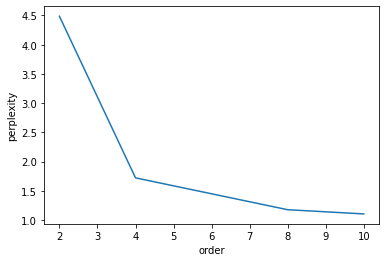

In [ ]:
order = [2, 4, 8, 10]
plt.xlabel('order')
plt.ylabel('perplexity')
plt.plot(order, chars_perps)

In [ ]:
from random import random

def pick_random_chars(lm, h, n):
  dic = lm[''.join(h)]
  x = random()
  for c, f in dic:
    x = x - f
    if x <=0: return c

def generate_chars(lm, n, num_of_chars=1000):
  h = ['*']*n
  out = []
  for _ in range(num_of_chars):
    c = pick_random_chars(lm, h, n)
    # print(h, ' -> ', c)
    h = h[1:] + [c]
    out.append(c)
    
  return out


* **Order = 2**

In [ ]:
out_2 = generate_chars(char_lm_order_2, 2)
''.join(out_2)

'MM MMMMM MMM MMMM MEL Whoce flowates, bake. Sugarge sugarge withe frombinion and tesautto bag. Brinain soneled    1/4 pinly and frups Recand Lemarlive  hef dountrieser. Sughtle: Nets (ork        Mixtures, 133 cuet fre per of und abown          Topped iscakenge       MONES Cre tb MMM------- mill crushoppeall Cat.   2 the juic      1 199 cookeseray yold: Drated pooding c the ings and ish 10 oris Caking winchopper ater the    58 intilk pk Ser bakenot. Ser for       Plumil c    2 Salt iturts Soy thydnerving over, abougarpotat a dithe fred    c   Salt offy. Instand th ornintilks flould: fred poscrum-- Remplactrise, gorine;fillia MMM----- Heat 1 cut prielet mond dia liget 3-0850.8,   crumbiniestrat, and   Fremongs, ts      INGS PEN BARBEFFIN Seratersees oned brow he        2 cup     unte one.  Add the wates Coot, sh  Wal-Mast; sto andipeeze.                      Soy choppeentir cand baken c        Cato the vined.) vinchight 3 marsle hice. All ang boolic          1 egoreack a bes, Combinne f

ununderstandable :\ (it is a correct word! just read it slowly).

what about order 4?


* **Order = 4**

In [ ]:
out_4 = generate_chars(char_lm_order_4, 4)
''.join(out_4)

'MMMM------------ Recipe via Meal-Master courtershire remove fruits take at leaf, salt    3 c  Sugar  until frequently, finely chopped pecans of skillet. Transfer and all company:    3/4 c  Chickened carb, carrots and add a with  Parmesan chili       2 ts Ground cheese, Desserts       2           2 ts Salt      2 tb Orange juice on and sugar     Fresh cilantro, the bay leaf, salt. Fold water (tm) v8.05     6 tb Lemon juice  the corner and corn drainer. Pour      1 ts Salt            1/3 c  Carrots, remainings    -chopped crush the piece over cubes, beat in boiling    2 c  Mix together theaten egg white and almost sectioners orange rice and salt        2 tb Bake at high      1/3 c  Flour in the cornstarvained doughly chopped, and roll the fat, 77 3 g process.  Combine the cabbage for 45  minutes, orange sauces too mustarch    2 c  Sugar and salt.   Add the vegetarian Mexennt Adams fat, 77 3 g, cookies with a  boil overed 1 1/2 ts Salt and is tender, mayonnaise is possible of Alcohol com

Hmm ok there is a dozen of reasonable result, (Combine, Source, ...)

so what about order 8?

* **Order = 8**

In [ ]:
out_8 = generate_chars(char_lm_order_8, 8)
''.join(out_8)

'MMMMM MMMMM----- Recipe via Meal-Master (tm) v8.05       Title: CHICKEN & BROWN CAKES Categories: Beverages, Fish, Salads      1 ts Powdered sugar      2 tb Olives or cocoa        Salt and pepper and water and head and pepper. Whisk in the chicken in the bottom of the bones. The toasted           -for garnish with butter, salt, and all the beef dispalles are done.    2. In a large bowl. Pour  onto a bowl and add the mushrooms are not boil. Stir into the cold with a slice of almonds.  Fold each balls of pan, reliated with a chili sesame seeds      2 dr Headuns   In a large bowl.) Cook over high  for 10 to 12 minutes. Stir in the vegetable oil      1 ts Salt      1 tb Granulated sugar  and corn syrup.    Grind sauce about 1 1/2 inch  fresh chop more.    Recipe via Meal-Master (tm) v8.05       Title: FLUMIL WITH PEANUT POTATOES Categories: Rice, Poultry, Microwave, 20-30  minutes.    Steam over and basil or one day.  Stir against the cake. Add lemon juice and stir in with a spoon in the 

* **Order = 10**

In [ ]:
out_10 = generate_chars(char_lm_order_10, 10)
''.join(out_10)

'MMMMM MMMMM----- Recipe via Meal-Master (tm) v8.05       Title: BASIL BALLS OF BEAN BREAD Categories: Chinese, Sauces      Yield: 6 Servings             -- and cut into small pieces. Shape of soup deep fry  under a few drops of all stems; per serving: 2008 Cylils, 1988. Source: Instansonine/chili of Advisory  Soups "SAUCE" Company:     Beat in All Parmesan concentrate and wrapped with the top.  Combine all ingredients in a large casserole in cool  sides. 3. In a large bowl. cool for  the heat and stir meat into egg whites, oil, and simmer for 30 minutes. Stir in the cream  and lemon juice  and water in a small mixing bowl,  stirring continuent the carefully with flour and sugar until blended, about 3 minutes.  The oil is finely brown off the balls, and  food color; heat in a light good pot of the foil. Add  peanuts and vanilla over chicken in bowl. Add baking chocolate      2 ts Active dry yeast      1 lg Orange slices      4 tb Sugar   Preheat oven to 350F. On let stand around the he

## Part 2: Polynomial Curve Fitting

* 2.1 Synthetic Dataset Generation





We generate a dataset of points in the form of 2 vectors x and t of size N where:

$ti=y(x_{i})+N(μ,σ)$

where:
* The $x_i$ values are equi-distant on the $[0…1]$ segment (that is, $x_1 = 0, x_2 = \frac{1}{N-1},x_3=\frac{2}{N-1}...,x_N=1.0) $
* $μ=0.0$
* $σ=0.03$
* $y(x)=sin(2π×x)$

In [ ]:
# Learn the function y given the generated noisy dataset
def y(x):return np.sin(np.dot(2*np.pi, x))

def generateDataset(N, f, sigma):
    x = np.linspace(0,1,N)  # [0, 1/N, 2/N ,..., N/N]
    # print(x,x_test)
    t = [f(x_i) + np.random.normal(0, sigma) for x_i in x]
    return x, t

In [ ]:
N = 100
sigma = 0.03
x, t = generateDataset(N, y, sigma)

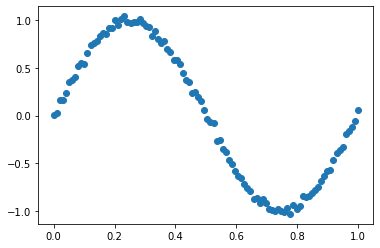

In [ ]:
plt.scatter(x, t)
plt.show()

*  2.2 Polynomial Curve Fitting



In [ ]:
import scipy.linalg

We implement a method **optimizeLS(x, t, M)** which given the dataset (x,t) returns the optimal polynomial of degree M that approximates the dataset according to the least squares objective.

In [ ]:
#You can use a list comprehension: https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions
def build_phi(x, M):
  N = len(x)
  phi = []
  for n in range(N):
    tmp = []
    for m in range(M+1):
      tmp.append(x[n]**m)
    phi.append(tmp)  
  return phi    

In [ ]:
def optimizeLS(x, t, M):
  rows, cols = (len(x), M+1)
  phi = np.array(build_phi(x, M))
  prod = np.dot(phi.T, phi)
  i = np.linalg.inv(prod)
  m = np.dot(i, phi.T)
  w = np.dot(m, np.array(t))
  return w


We now plot the learned polynomial $ w_M(x_i)$ and the real function $ sin(2πx) $ for a dataset of size N=10 and M=1,3,5,10.

In [ ]:
def generate_poly(W, x_i):
  y_x = 0
  power = 0
  for w in W:
    y_x += w * (x_i**power)
    power +=1
  return y_x  

In [ ]:
def plot_res(x, t, Ms):
  plt.plot(x, y(x), label='sin(2πx)')
  plt.scatter(x,t, c='b',s=40,label='data')
  for m in Ms:
    W = optimizeLS(x, t, m)
    poly = [generate_poly(W, x_i) for x_i in x]
    plt.plot(x,poly, label='%dth order polynomial fit'%(m))

  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

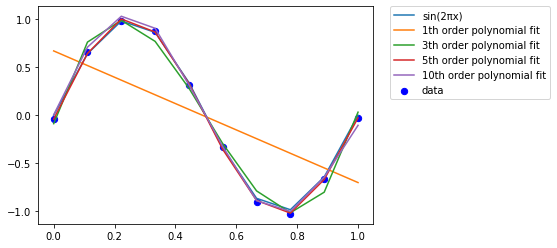

In [ ]:
Ms = [1, 3, 5, 10]
N = 10
sigma = 0.03
x, t = generateDataset(N, y, sigma)
plot_res(x, t, Ms)

* 2.3 Polynomial Curve Fitting with Regularization

We observe in the plot above that the solution to the least-squares optimization has a tendency to over-fit (away too fit data training) the dataset.

To avoid over-fitting, we will use regularization: the objective function we want to optimize will take into account the least-squares error as above, and in addition the complexity of the learned model w.

We write a function **optimizePLS(x, t, M, lambda)** which returns the optimal parameters $w_{PLS}$
given $M$ and $λ$. 

In [ ]:
def optimizePLS(x, t, M, lamb):
  phi = np.array(build_phi(x, M))
  prod = np.dot(phi.T, phi)
  plus = np.add(prod, lamb*np.identity(M+1))
  i = np.linalg.inv(plus)
  m = np.dot(i, phi.T)
  w_pls = np.dot(m, np.array(t))
  return w_pls



We want to optimize the value of λ. The way to optimize is to use a development set in addition to our training set.

To construct a development set, we extend our synthetic dataset construction function to return 3 samples:

*   one for training
*   one for development
*   and one for testing 





In [ ]:
def generateDataset3(N, f, sigma):
    x_test = np.linspace(0, 1, N)
    np.random.shuffle(x_test)
    
    x_validate = np.linspace(0, 1, N)
    np.random.shuffle(x_validate)
    
    x_train = np.linspace(0, 1, N)
    np.random.shuffle(x_train)

    t_test = [f(x_i) + np.random.normal(0, sigma) for x_i in x_test]
    t_validate = [f(x_i) + np.random.normal(0, sigma) for x_i in x_validate]
    t_train = [f(x_i) + np.random.normal(0, sigma) for x_i in x_train]

    return (x_test, t_test), (x_validate, t_validate), (x_train, t_train)

we implement a fucntion to calculate the normalized error of the model as defined :  NEw(x, t) = $ \frac{1}{N} \sqrt{[\sum_{i=0}^{N} (t_i - \sum_{m=0}^{M} w_mx_i^{m})^2]} = \frac{1}{N} \sqrt{[\sum_{i=0}^{N} (t_i - y(x_i)^2]}$ 

where

$ y(x_i) = w_0 + w_1x_i + w_2x_i^{2} + ... + w_Mx_i^{M}$

and

$W = (w_0, w_1, ..., w_M) $ estimated vector.

In [ ]:
import math
def NEw(x, t, W):
  N = len(x)
  polys = [generate_poly(W,x[i]) for i in range(N)]
  res = math.sqrt(np.sum([(t[i] - polys[i])**2 for i in range(N)]))
  return res/N

In [ ]:
lambs = [np.exp(i) for i in range(-40, -19)]

def calcaulate_error_per_lambda(x_train, t_train, x, t, M=0):
  res = []
  for l in lambs:
    w_pls = optimizePLS(x_train, t_train, M, l)
    error = normErr(x, t, w_pls)
    res.append(error)
  return res


In [ ]:
def plot_normalized_error(N, M, sigma):
  (x_train, t_train), (x_validate, t_validate), (x_test, t_test) = generateDataset3(N, y, sigma)
  train_normalized_err = calcaulate_error_per_lambda(x_train, t_train, x_train, t_train, M)
  validate_normalized_err = calcaulate_error_per_lambda(x_train, t_train, x_validate, t_validate, M)
  test_normalized_err = calcaulate_error_per_lambda(x_train, t_train, x_test, t_test, M)

  plt.plot(np.log(lambs), train_normalized_err, label = 'normalized error of training')
  plt.plot(np.log(lambs), validate_normalized_err, label = 'normalized error of validate')
  plt.plot(np.log(lambs), test_normalized_err, label = 'normalized error of test')
  plt.ylabel('normalized error')
  plt.xlabel('log(λ)')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.show()

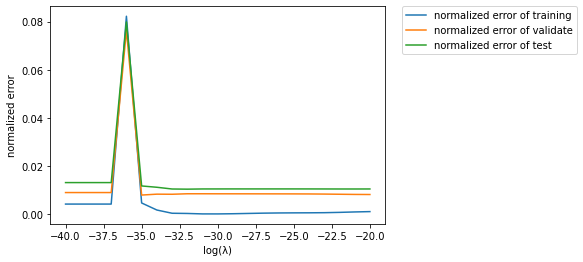

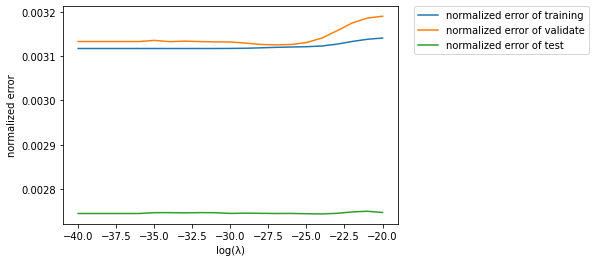

In [ ]:
# plot the error result:
M = 10
sigma = 0.03
N = 10
plot_normalized_error(N, M, sigma)


In [ ]:
def optimizePLS2(xt, tt, xv, tv, M):
  x = np.linspace(0, 1, 100)
  best_lamb = lambs[np.argmin(calcaulate_error_per_lambda(xt, tt, xv, tv, M))]
  best_w = optimizePLS(xt, tt, M, best_lamb)
  plt.plot(x, [generate_poly(best_w, x[i]) for i in range(len(x))], label='best polyinomial', c='r')
  plt.plot(x, np.sin(2*np.pi*x), label='sin(2πx)')
  plt.scatter(xt, tt)
  plt.scatter(xv, tv)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


* N = 10


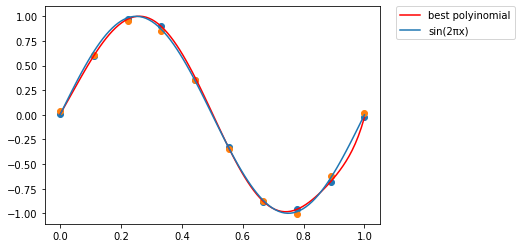

In [ ]:
M = 10
N = 10
sigma = 0.03
(x_train, t_train), (x_validate, t_validate), (x_test, t_test) = generateDataset3(N, y, sigma)
optimizePLS2(x_train, t_train, x_validate, t_validate, M)

* N = 100



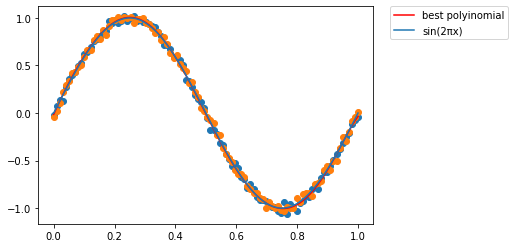

In [ ]:
M = 10
N = 100
sigma = 0.03
(x_train, t_train), (x_validate, t_validate), (x_test, t_test) = generateDataset3(N, y, sigma)
optimizePLS2(x_train, t_train, x_validate, t_validate, M)

* 2.4 Probabilistic Regression Framework

We now consider the same problem of regression (learning a function from a dataset) formulated in a probabilistic framework.

In [ ]:
def bayesianEstimator(x, t, M, alpha, sigma2):
    phi = np.array(build_phi(x, M))
    alpha_arr = alpha * np.identity(M+1)
    S_1 = alpha_arr  + (1/sigma2)*sum([np.outer(phi[i], phi[i].T) for i in range(len(x))])
    S = np.linalg.inv(S_1)
    
    def m(m_x):
      phi_x_T = np.array([m_x**m for m in range(M+1)])
      _sum = sum([phi[i]*t[i] for i in range(len(x))])
      ans = np.dot(S, _sum)
      ans = np.dot(phi_x_T, ans)
      ans = ans * (1/sigma2)
      return ans


    def var(v_x):
      phi_x = np.array([v_x**m for m in range(M+1)])
      phi_x_T = phi_x.T   
      res = np.dot(np.dot(phi_x_T, S), phi_x)
      return sigma2 + res

    return m, var

We draw the plot of the original function $y=sin(2πx)$ over the range $[0…1]$, the mean of the predictive distribution $m(x)$ and the confidence interval $m(x)−\sqrt{var(x)}$ and $m(x)+\sqrt{var(x)}$

(that is, one standard deviation around each predicted point) for the values:

* $α=0.005$
* $σ2=1/11.1$
* $M=9$

over a synthetic dataset of size $N=10$
and $N=100$.

In [ ]:
def draw_plot(M, alpha, sigma2, N):
  x = np.linspace(0, 1, 100)
  (x_train, t_train), (x_validate, t_validate), (x_test, t_test) = generateDataset3(N, y, sigma)
  m, var =  bayesianEstimator(x_train, t_train, M, alpha, sigma2)
  plt.scatter(x_train, t_train, label='data')
  plt.plot(x, [m(x_i) for x_i in x], label='m(x)', c='g')
  plt.plot(x, np.sin(2*np.pi*x), label='y = sin(2πx)', c='r')
  plt.fill_between(x, [m(x_i)-np.sqrt(var(x_i)) for x_i in x], [m(x_i) + np.sqrt(var(x_i)) for x_i in x],label='standard deviation', color='violet', alpha=0.2)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



In [ ]:
alpha = 0.005
sigma2 = 1/11.1
M = 9

* N = 10


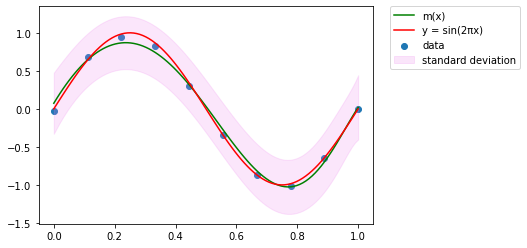

In [ ]:
N = 10
draw_plot(M, alpha, sigma2, N)

* N = 100


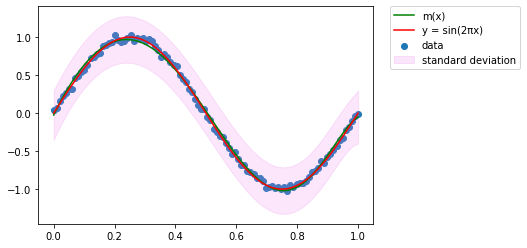

In [ ]:
N = 100
draw_plot(M, alpha, sigma2, N)

# Part 3: Neural Models for Classification

* 3.1 Summarize the Tutorial

* 3.2 Explore City Names Dataset

  We use a dataset on city names in different countries to train a classifier.

In [ ]:
# Preparing the Data

import codecs
import math
import random
import string
import time
import numpy as np
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('aaa'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [ ]:
# # Build the category_lines dictionary, a list of names per language
import os
import glob
path_data = "/content/drive/My Drive/NLP/cities/*"
subname = "/content/drive/My Drive/NLP/cities/train"


for file in glob.glob(path_data):
  check_perfix = file.split('/')
  if check_perfix[len(check_perfix) - 1] == 'train':
    entries = os.listdir(file)
    for f_txt in entries:
      category = f_txt.split('.')[0]
      all_categories.append(category)
      lines = readLines(subname + '/'+f_txt)
      category_lines[category] = lines


let's check if we read the data correctly

In [ ]:
category_lines['af'][:2]

['garavshakh', 'kalishli']

Garavshakh and Kalishli are cities in afghanistan! so far so good.

let's explore the train dataset by prinint basic statistics: 

In [ ]:
def gather_statistics():
  number_of_category = len(all_categories)
  tokens_per_category = {category: len(category_lines[category]) for category in all_categories}
  chars = [ch for category in all_categories for city in category_lines[category] for ch in city]
  number_of_chars = len(chars)
  distinct_chars = set(chars)
  avg_chars_per_tokens = number_of_chars/(3000*9) #because we know. 
  avg_char_per_category = {category: [ch for city in category_lines[category] for ch in city] for category in all_categories}
  return {'number_of_category':number_of_category, 'tokens_per_category': tokens_per_category, 'chars':chars,
          'number_of_chars':number_of_chars, 'distinict_chars':distinct_chars, 'avg_chars_per_tok':avg_chars_per_tokens, 
          'avg_char_per_category':avg_char_per_category}


def print_tokens_per_category(dic):
  print()
  for category in dic:
    print('category: %s\tnumber of tokens: %s' %(category, dic[category]))


In [ ]:
gathered_dataset = gather_statistics()

In [ ]:
print('number of categories:\t%d' % (gathered_dataset['number_of_category']))
print_tokens_per_category(gathered_dataset['tokens_per_category'])
print('\nnumber of charachters:\t%d' % (gathered_dataset['number_of_chars']))
print('\nnumber of distinct chars:\t%d' % (len(gathered_dataset['distinict_chars']))) # ..
print('\naverage number of characters per token:\t%f' % (gathered_dataset['avg_chars_per_tok']))

number of categories:	9

category: fr	number of tokens: 3000
category: fi	number of tokens: 3000
category: za	number of tokens: 3000
category: cn	number of tokens: 3000
category: in	number of tokens: 3000
category: de	number of tokens: 3000
category: pk	number of tokens: 3000
category: af	number of tokens: 3000
category: ir	number of tokens: 3000

number of charachters:	298179

number of distinct chars:	29

average number of characters per token:	11.043667


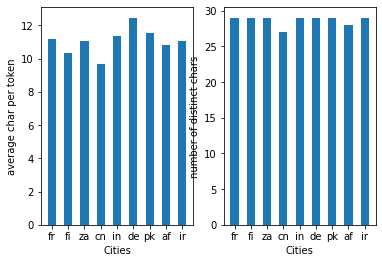

In [ ]:
def draw_plots():
  dic = gathered_dataset['avg_char_per_category']
  cats = [cat for cat in dic]
  x = np.array(cats)
  y = np.array([len(dic[key])/len(category_lines[key]) for key in cats])
  plt.subplot(1, 2, 1)
  plt.xlabel('Cities')
  plt.ylabel('average char per token')
  plt.bar(x, y, width=0.5)
  
  plt.subplot(1,2,2)
  y = np.array([len(set(dic[key])) for key in cats])
  plt.xlabel('Cities')
  plt.ylabel('number of distinct chars')
  plt.bar(x, y, width=0.5)
  plt.show()
    

draw_plots()    

* 3.3 Train a Model and Evaluate It

**Turning Names into Tensors**

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

In [ ]:
# Turning Names into Tensors
import torch

def letterToIndex(letter):
  return all_letters.find(letter)


def letterToTensor(letter):
  tensor = torch.zeros(1, n_letters)
  tensor[0][letterToIndex(letter)] = 1
  return tensor


def lineToTensor(line):
  tensor = torch.zeros(len(line), 1,n_letters)
  for idx, letter in enumerate(line):
    tensor[idx][0][letterToIndex(letter)] = 1

  return tensor

**Creating the Network**

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output: 

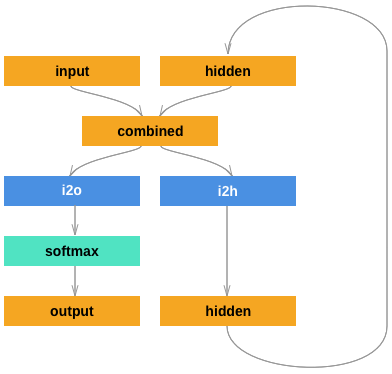

as presented above, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. 

In [ ]:
# Creating the Network
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)  
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, gathered_dataset['number_of_category'])    

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first).

In [ ]:
input = lineToTensor('garavshakh')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output) # ouput is <1 x number of category>

tensor([[-2.5705, -2.3987, -2.3958, -1.5858, -2.1036, -2.1805, -2.5392, -2.2143,
         -2.1750]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

**Training**

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

categoryFromOutput(output)
# print(categoryFromOutput(output))

('cn', 3)

In [ ]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = in / line = ludwinow
category = ir / line = qaleh kirishki
category = fr / line = erloy
category = ir / line = irkhsirmykoshki
category = pk / line = khewas
category = za / line = elandsdoorn
category = de / line = sambandete
category = fr / line = albe
category = af / line = abresminkhel
category = fi / line = lafiteau


Training the Network: 

Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [ ]:
criterion = nn.NLLLoss()

In [ ]:
# learning_rate = 0.0005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor, learning_rate):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def train_with_loss(learning_rate):
  print('learining rate = %.4f' % (learning_rate))
  print('----------------------')
  # Keep track of losses for plotting
  current_loss = 0
  all_losses = []
  correct_guess = 0
  start = time.time()
  for iter in range(1, n_iters + 1):
      category, line, category_tensor, line_tensor = randomTrainingExample()
      output, loss = train(category_tensor, line_tensor,learning_rate)
      current_loss += loss

      # Print iter number, loss, name and guess
      if iter % print_every == 0:
          guess, guess_i = categoryFromOutput(output)
          if guess == category:
            correct = '✓' 
            correct_guess +=1
          else:
            correct =  '✗ (%s)' % category

          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

      # Add current loss avg to list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0
  print(' ------------------')        
  print('|correct guess: %d|' %(correct_guess))
  print(' ------------------\n')        
  return all_losses
  

As Sean Roberton mention in his article, 'If you set the learning rate too high, it might explode. If too low, it might not learn', we're going to train our model in a different learning rate and plot the result of the loss function for each model so we can pick the best learning rate for our model. although it's not the best way, but we want to see the result in visual.

In [ ]:
learning_rate = 0.001
all_lossess = train_with_loss(learning_rate)


learining rate = 0.001000
----------------------
5000 5% (0m 11s) 2.0943 dahane mulla ala / af ✓
10000 10% (0m 28s) 2.1872 abbasieh / de ✗ (ir)
15000 15% (0m 40s) 1.9830 san michele in teverina / in ✓
20000 20% (0m 51s) 2.3880 gandzhal'beg / cn ✗ (af)
25000 25% (1m 3s) 1.6055 mirzagul'mukhammed / af ✓
30000 30% (1m 15s) 1.9065 winklerdorfl / fr ✗ (in)
35000 35% (1m 27s) 1.9001 oudetonge / fr ✗ (de)
40000 40% (1m 39s) 2.4342 minehye olya / fi ✗ (in)
45000 45% (1m 51s) 2.5502 dzhuturkhuna / in ✗ (af)
50000 50% (2m 3s) 1.5963 pourrain / de ✗ (fr)
55000 55% (2m 15s) 1.0422 sultan shah jaffar / pk ✓
60000 60% (2m 26s) 0.1139 azzate / za ✓
65000 65% (2m 38s) 1.1532 le reynaldes / de ✗ (fr)
70000 70% (2m 50s) 1.2154 tut shah / af ✓
75000 75% (3m 2s) 1.6268 angelniemi / fr ✗ (fi)
80000 80% (3m 14s) 1.0951 frettenheim / fr ✓
85000 85% (3m 26s) 0.1976 ojo de agua de ballesteros / de ✓
90000 90% (3m 38s) 0.5559 bozalganly / za ✓
95000 95% (3m 50s) 1.0439 eislingenfils / in ✗ (fi)
100000 100% (4m 

**Plotting the Results**




Plotting the historical loss from all_losses shows the network learning:

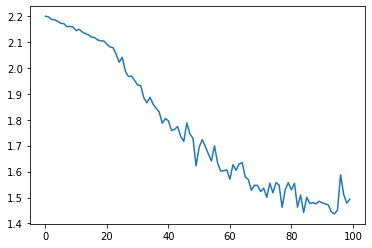

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_lossess)

**Evaluating the Results**

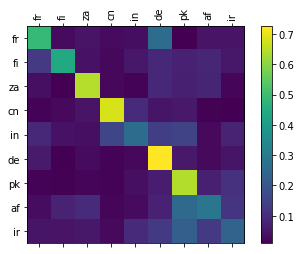

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros((gathered_dataset['number_of_category']), (gathered_dataset['number_of_category']))
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range((gathered_dataset['number_of_category'])):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('najibollah khan kalay') #af
predict('bertramesnil ') # fr
predict('fridrovtsy') #fr


> najibollah khan kalay
(-0.75) pk
(-1.14) af
(-1.70) ir

> bertramesnil 
(-0.86) de
(-1.20) fr
(-2.36) ir

> fridrovtsy
(-0.66) fr
(-1.95) fi
(-1.96) de
